In [41]:
import sys
from pathlib import Path
main_path = Path().absolute().parent
data_path = main_path / 'data'
setting_path = main_path / 'setting_files'

sys.path.append(str(main_path / 'src'))
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
import json
from nlu_utils import NLUTokenizer
from nlu_models import NLUModel
from nlu_utils import NLUDataModule
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
device = torch.device('cuda')
data_dict = defaultdict(dict)

for set_p in (setting_path.glob('x_ce*')):
    with (set_p).open('r') as file:
        settings = yaml.load(file, Loader=yaml.FullLoader)
    
    exp_name = set_p.name.lstrip('x_').rstrip('.yml')
    data_module_settings = settings['data_module']
    model_settings = settings['model']
    trainer_settings = settings['trainer']

    data_module = NLUDataModule(
        train_path=data_path / data_module_settings['train_file'], 
        valid_path=data_path / data_module_settings['valid_file'],
        test_path=data_path / data_module_settings['test_file'],
        labels_path=data_path / data_module_settings['labels_file'],
        batch_size=64, 
        max_len=data_module_settings['max_len'],
        num_workers=0,
        seed=settings['seed']
    )
    data_module.prepare_data()
    ckpt_path = list((main_path / 'logs' / 'nlu_simple' / exp_name / 'checkpoints').glob('*.ckpt'))[0]
    model = NLUModel.load_from_checkpoint(ckpt_path)
    model.to(device)
    data_dict[exp_name]['tags_pred'] = []
    data_dict[exp_name]['tags_target'] = []
    data_dict[exp_name]['intent_pred'] = []
    data_dict[exp_name]['intent_target'] = []
    test_loader = data_module.test_dataloader()
    for x in tqdm(test_loader, total=len(test_loader), desc=f'Testing: {exp_name}'):
        tags = x['tags'].view(-1).tolist()
        intent = x['intent'].tolist()
        test_inputs = {k: x[k].to(device) for k in ['input_ids', 'token_type_ids', 'attention_mask']}
        o = model.predict(**test_inputs)
        data_dict[exp_name]['tags_pred'].extend(o['tags'])
        data_dict[exp_name]['tags_target'].extend(tags)
        data_dict[exp_name]['intent_pred'].extend(o['intent'])
        data_dict[exp_name]['intent_target'].extend(intent)
    for k in ['tags_pred', 'tags_target', 'intent_pred', 'intent_target']:
        data_dict[exp_name][k] = np.array(data_dict[exp_name][k])
        
    print("END TEST")

loading: 100%|███████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 179911.23it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l3_tk3_0:   0%|          | 0/6 [00:00<?, ?it/s]

END TEST


loading: 100%|███████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 367001.60it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l3_tk3_1:   0%|          | 0/6 [00:00<?, ?it/s]

END TEST


loading: 100%|███████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 182513.65it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l3_tk3_3:   0%|          | 0/6 [00:00<?, ?it/s]

END TEST


loading: 100%|█████████████████████████████████████████████████████████████████| 1364/1364 [00:00<00:00, 227974.92it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l5_tk3_0:   0%|          | 0/22 [00:00<?, ?it/s]

END TEST


loading: 100%|██████████████████████████████████████████████████████████████████| 1364/1364 [00:00<00:00, 16863.06it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l5_tk3_1:   0%|          | 0/22 [00:00<?, ?it/s]

END TEST


loading: 100%|█████████████████████████████████████████████████████████████████| 1364/1364 [00:00<00:00, 194447.37it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l5_tk3_3:   0%|          | 0/22 [00:00<?, ?it/s]

END TEST


loading: 100%|███████████████████████████████████████████████████████████████| 14158/14158 [00:00<00:00, 240501.54it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l7_tk3_0:   0%|          | 0/222 [00:00<?, ?it/s]

END TEST


loading: 100%|███████████████████████████████████████████████████████████████| 14158/14158 [00:00<00:00, 244698.56it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l7_tk3_1:   0%|          | 0/222 [00:00<?, ?it/s]

END TEST


loading: 100%|███████████████████████████████████████████████████████████████| 14158/14158 [00:00<00:00, 244759.07it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_l7_tk3_3:   0%|          | 0/222 [00:00<?, ?it/s]

END TEST


loading: 100%|███████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 147411.56it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing: ce_noaug:   0%|          | 0/5 [00:00<?, ?it/s]

END TEST


In [150]:
from sklearn.metrics import confusion_matrix

def get_cfm(x, labels, typ):
    cfm = confusion_matrix(x[f'{typ}_target'], x[f'{typ}_pred'], labels=range(len(labels)), normalize='true') * 100
    df_cfm = pd.DataFrame(cfm, columns=labels, index=labels)
    return df_cfm

In [151]:
intent_labels = list(map(lambda x: x[0], sorted(data_module.intents2id.items(), key=lambda x: x[1])))
tags_labels = list(map(lambda x: x[0], filter(lambda x: x[1] < 100, sorted(data_module.tags2id.items(), key=lambda x: x[1]))))

for k, x in data_dict.items():
    data_dict[k]['tags_cfm'] = get_cfm(x, labels=tags_labels, typ='tags')
    data_dict[k]['intent_cfm'] = get_cfm(x, labels=intent_labels, typ='intent')

C:\Users\simon\AppData\Local\Temp/ipykernel_3332/3946553898.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


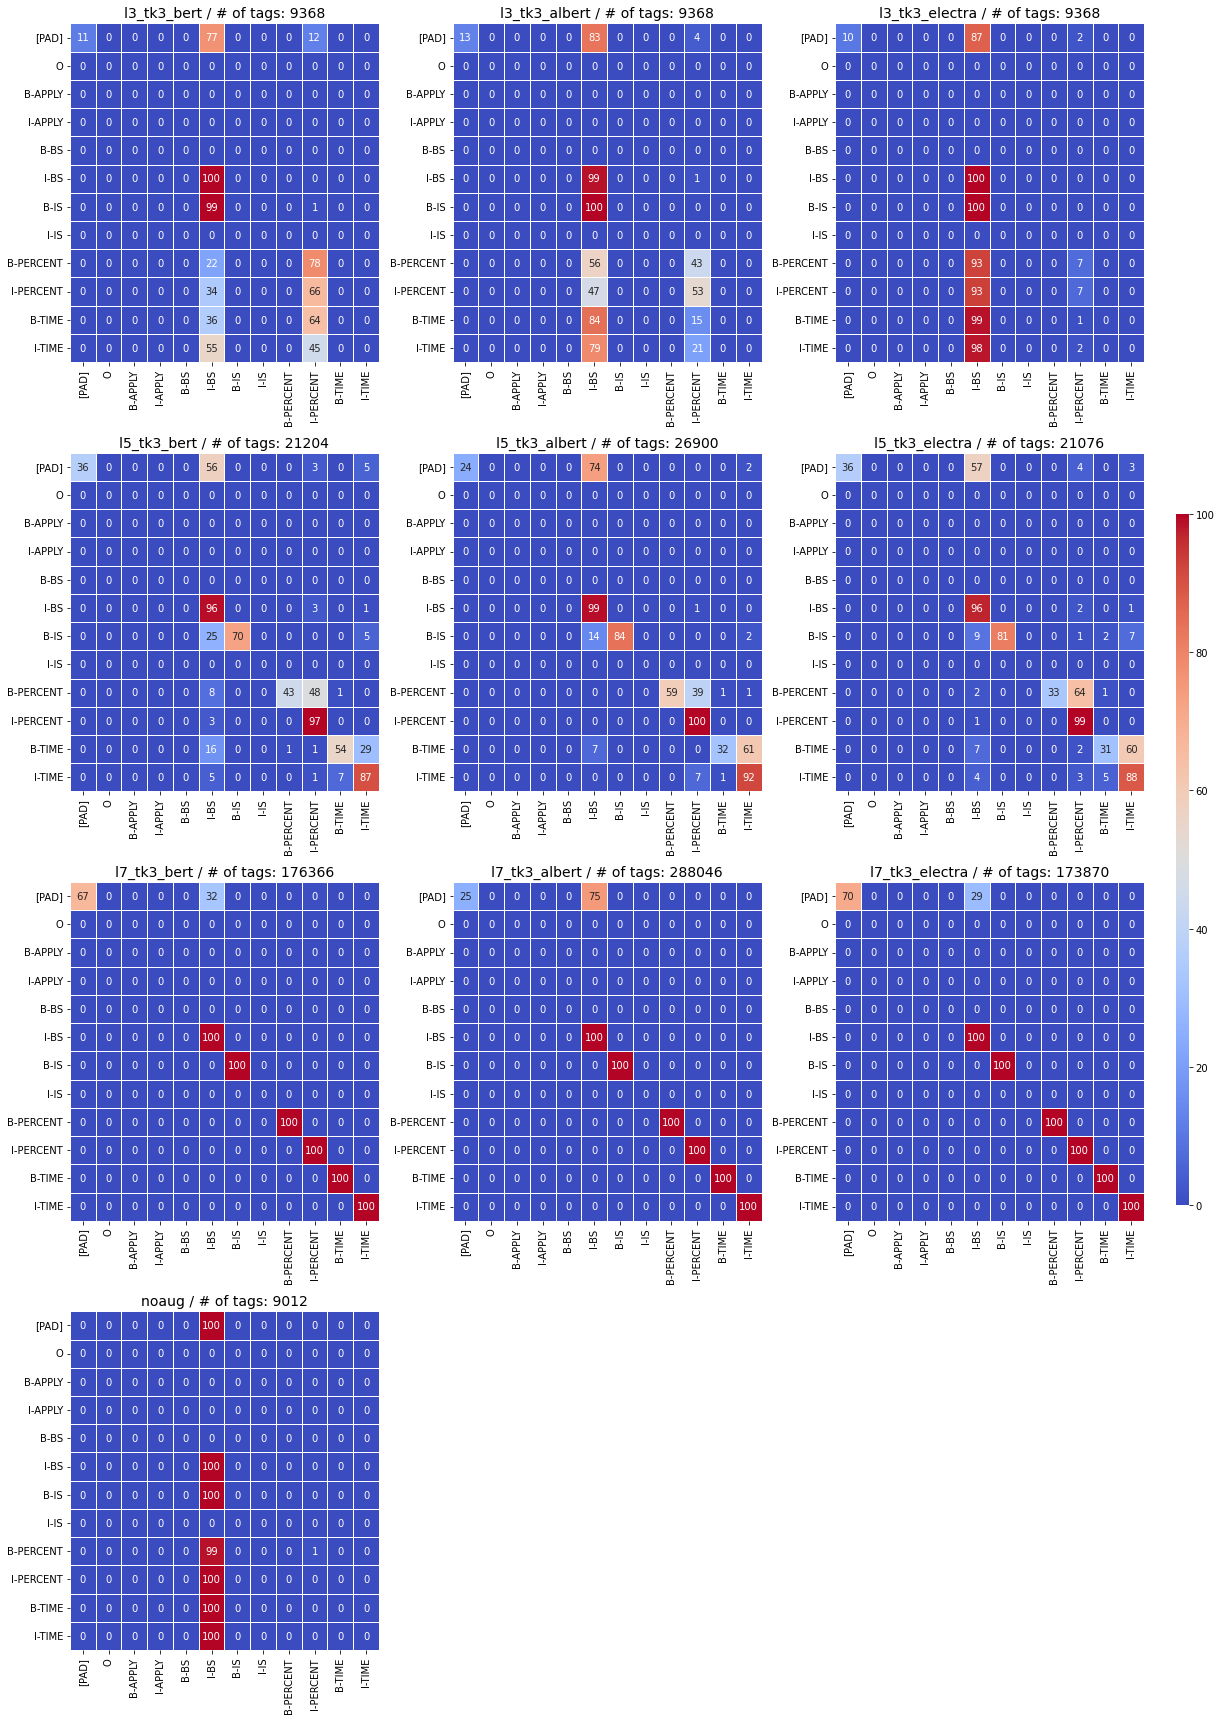

In [161]:
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
cbar_ax = fig.add_axes([.91, .3, .01, .4])
key = 'tags_cfm'

for i, ((k, x), ax) in enumerate(zip(data_dict.items(), axes.flatten())):
    sns.heatmap(data_dict[k][key] , ax=ax, linewidths=.5, cmap='coolwarm', annot=True, fmt='.0f', cbar_ax=cbar_ax)
    k_name = k.lstrip('ce_')
    if len(k_name.split('_')) > 1:
        *a, b = k_name.split('_')
        title = '_'.join(a) + '_' + bert_m_dict[int(b)]
    else:
        title = k_name
    
    ax.set_title(f'{title} / # of tags: {len(data_dict[k]["tags_target"])}', fontsize=14)
    
plt.tight_layout(rect=[0, 0, .9, 1])
axes[-1, 1].axis('off')
axes[-1, 2].axis('off')
plt.show()

In [162]:
fig.savefig(main_path.parent / 'Test' / 'cf_tags.png')

C:\Users\simon\AppData\Local\Temp/ipykernel_3332/2416294031.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


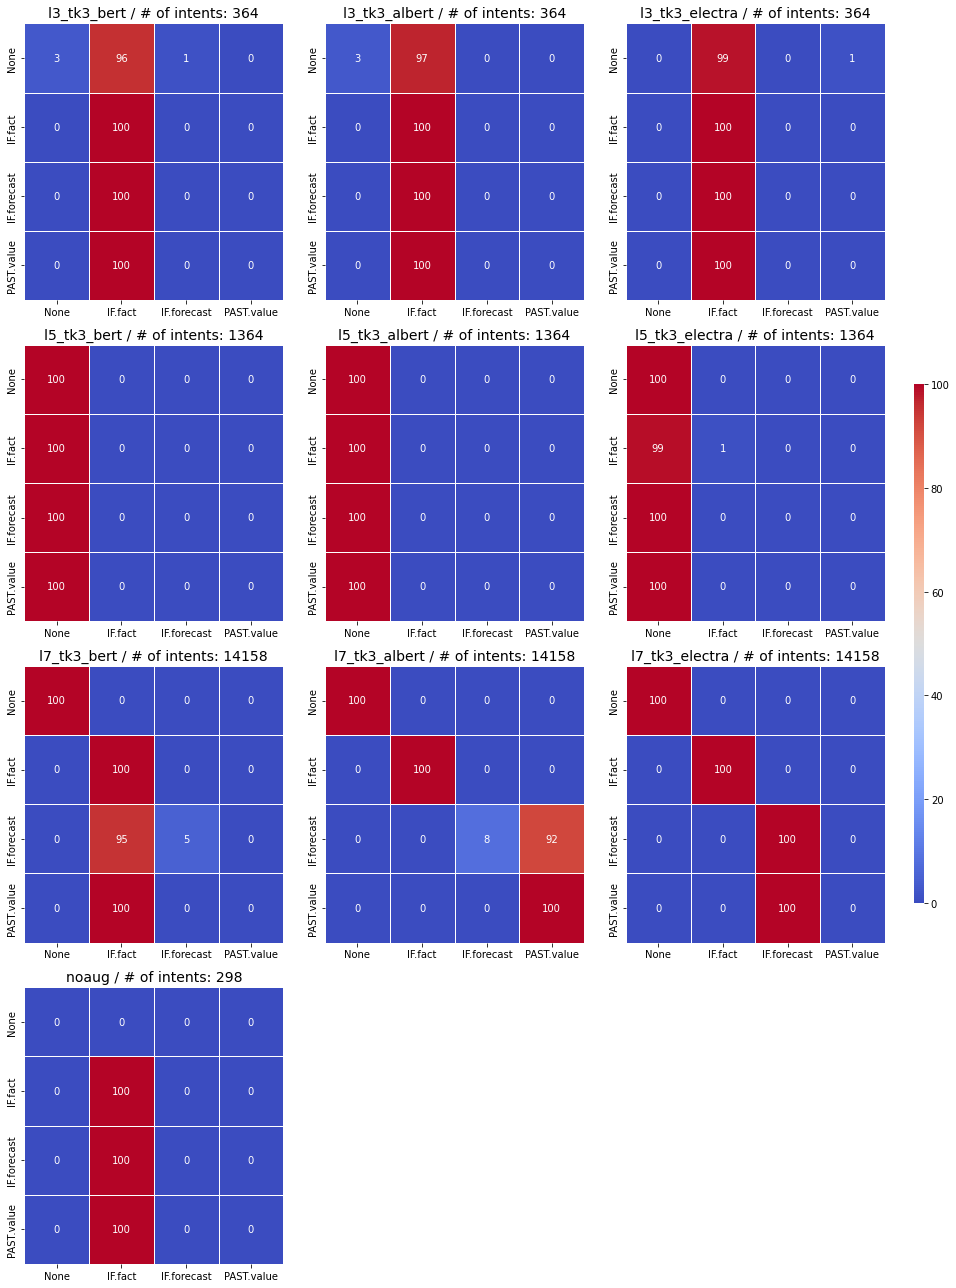

In [163]:
fig, axes = plt.subplots(4, 3, figsize=(14, 18))
cbar_ax = fig.add_axes([.91, .3, .01, .4])
key = 'intent_cfm'

for i, ((k, x), ax) in enumerate(zip(data_dict.items(), axes.flatten())):
    sns.heatmap(data_dict[k][key] , ax=ax, linewidths=.5, cmap='coolwarm', annot=True, fmt='.0f', cbar_ax=cbar_ax)
    k_name = k.lstrip('ce_')
    if len(k_name.split('_')) > 1:
        *a, b = k_name.split('_')
        title = '_'.join(a) + '_' + bert_m_dict[int(b)]
    else:
        title = k_name
    
    ax.set_title(f'{title} / # of intents: {len(data_dict[k]["intent_target"])}', fontsize=14)
    
plt.tight_layout(rect=[0, 0, .9, 1])
axes[-1, 1].axis('off')
axes[-1, 2].axis('off')
plt.show()

In [164]:
fig.savefig(main_path.parent / 'Test' / 'cf_intent.png')

In [27]:
fig, axes = plt.subplots(4, 3, figsize=(14, 18))
cbar_ax = fig.add_axes([.91, .3, .01, .4])

for i, ((k, x), ax) in enumerate(zip(data_dict.items(), axes.flatten())):
    sns.heatmap((data_dict[k]['intent_cfm'] / data_dict[k]['intent_cfm'].max()).fillna(0.0), ax=ax, linewidths=.5, cmap='coolwarm', cbar_ax=cbar_ax)
    k = k.lstrip('ce_')
    if len(k.split('_')) > 1:
        *a, b = k.split('_')
        title = '_'.join(a) + '_' + bert_m_dict[int(b)]
    else:
        title = k
    
    ax.set_title(title, fontsize=14)
    
plt.tight_layout(rect=[0, 0, .9, 1])
axes[-1, 1].axis('off')
axes[-1, 2].axis('off')
plt.show()

In [165]:
23324 / 6218 

3.7510453522032807

In [166]:
242100 / 23324

10.379866232207169

In [28]:
tokenizer = NLUTokenizer()

In [7]:
set_p.name.lstrip('x_ce_').rstrip('.yml')

'l3_tk3_0'

In [16]:
list((main_path / 'logs' / 'nlu_simple' / exp_name / 'checkpoints').glob('*.ckpt'))[0]

WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l3_tk3_0/checkpoints/epoch=35-step=251-val_loss=26.6686.ckpt')

In [ ]:
with (setting_path / 'train_settings.yml').open('r') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)





In [8]:
test_results = defaultdict()
checkpoint_paths = []
for p in (main_path / 'logs' / 'nlu_simple').glob('*'):
    if p.name == '.ipynb_checkpoints':
        continue
    checkpoint_paths.append(list((p / 'checkpoints').glob('*.ckpt'))[0])

In [10]:
for p in checkpoint_paths:
    model = NLUModel.load_from_checkpoint(p)

[WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l3_tk3_0/checkpoints/epoch=35-step=251-val_loss=26.6686.ckpt'),
 WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l3_tk3_1/checkpoints/epoch=35-step=251-val_loss=24.6261.ckpt'),
 WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l3_tk3_3/checkpoints/epoch=35-step=251-val_loss=28.7343.ckpt'),
 WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l5_tk3_0/checkpoints/epoch=23-step=551-val_loss=4.2472.ckpt'),
 WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l5_tk3_1/checkpoints/epoch=23-step=551-val_loss=4.0007.ckpt'),
 WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l5_tk3_3/checkpoints/epoch=23-step=551-val_loss=4.4651.ckpt'),
 WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l7_tk3_0/checkpoints/epoch=11-step=2843-val_loss=0.0171.ckpt'),
 WindowsPath('C:/Users/simon/Desktop/Codes/FSQA/logs/nlu_simple/ce_l7_tk3_1/checkpoint

In [ ]:


checkpoint_path = str(main_path / 'logs' / 'nlu_simple' / s[0] / 'checkpoints' / s[1])

In [2]:
s = ('ce_l7_tk3_3', 'best_model.ckpt')
print(s)
checkpoint_path = str(main_path / 'logs' / 'nlu_simple' / s[0] / 'checkpoints' / s[1])
model = NLUModel.load_from_checkpoint(checkpoint_path)

('ce_l7_tk3_3', 'best_model.ckpt')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [190]:
from spacy.training import biluo_tags_to_spans, iob_to_biluo
from tokenizations import get_alignments 
from spacy.training import biluo_tags_to_offsets
import pandas as pd

with (data_path / 'labels_simple.json').open('r', encoding='utf-8') as file:
    ls = json.load(file)
tags2id = ls['tags']
intent2id = ls['intent']
id2tags = {v: k for k, v in ls['tags'].items()}
id2intent = {v: k for k, v in ls['intent'].items()}

from sparql import SparqlHandler, convert_to_string

sparql = SparqlHandler(data_path / 'AccountRDF.xml')
bs_role = sparql.get_role_dict('BS')
is_role = sparql.get_role_dict('IS')
bs_role_revserse = sparql.get_role_dict('BSR')
is_role_revserse = sparql.get_role_dict('ISR')

In [174]:
data = {
    0: 'How was the profit in the last year?',
    1: "if the noncurrent assets reduced by 62 percent in this fiscal year, what will be the effect to assets?",
    2: "What will be our revenue in 4th quarter?",
    3: "How is going to be about the revenue when the cost of sales increases by 20% in the previous year?"
}
text = data[3]
bert_encodes = tokenizer(
    text, 
    add_special_tokens=True, 
    truncation=True, 
    max_length=64,
    return_tensors='pt'
)
# o = model(**bert_encodes)
o = model.predict(**bert_encodes)

# DONE

In [176]:
intent = list(map(id2intent.get, o['intent']))[0]
tags = list(map(id2tags.get, o['tags']))

bert_tkns = [s.lstrip('##') for s in tokenizer.bert_tokenize(text)]
spacy_tkns = tokenizer.spacy_tokenize(text)
biluo_tags = iob_to_biluo(tags[1:-1])

In [177]:
a2b, b2a = get_alignments(bert_tkns, spacy_tkns)
mapped_tags = []
for i, tkn in enumerate(spacy_tkns):
    mapped_tkn_ids = b2a[i]
    ts = [biluo_tags[j] for j in mapped_tkn_ids]
    mapped_tags.append(ts[0])
doc = tokenizer.spacy_nlp(text)

# bert_ents = [('O', '') if t == 'O' else t.split('-') for t in mapped_tags]
# spacy_ents = iob_to_biluo([x.ent_iob_ if x.ent_iob_ == 'O' else f'{x.ent_iob_}-{x.ent_type_}' for x in doc])
# spacy_ents = [x.replace('DATE', 'TIME') for x in spacy_ents]
# spacy_ents = [('O', '') if t == 'O' else t.split('-') for t in spacy_ents]
# for i, (b_ent, s_ent) in enumerate(zip(bert_ents, spacy_ents)):
#     if b_ent[1] == '' and s_ent[1] != '':
#         bert_ents[i] = s_ent
#     elif b_ent[1] == s_ent[1] and b_ent[0] != s_ent[0]:
#         bert_ents[i] = s_ent
# print(list(map(lambda x: x[0] if x[0] == 'O' else '-'.join(x), bert_ents)))
# print(list(map(lambda x: x[0] if x[0] == 'O' else '-'.join(x), spacy_ents)))
# ensembled_tags = list(map(lambda x: x[0] if x[0] == 'O' else '-'.join(x), bert_ents))
ensembled_tags = mapped_tags
doc.ents = biluo_tags_to_spans(doc, ensembled_tags)

entities = []
for s, e, ent in biluo_tags_to_offsets(doc, ensembled_tags):
    lemma = ' '.join([x.lemma_ for x in tokenizer.spacy_nlp(text[s:e])])
    entities.append((lemma, ent.upper()))

nlu_results = defaultdict()
nlu_results['tags'] = defaultdict()
nlu_results['intent'] = None if intent == 'None' else intent
accounts = []
for word, tag in entities:
    if tag in ['BS', 'IS']:
        accounts.append((word, tag))
    else:
        nlu_results['tags'][tag] = word

nlu_results['tags']['ACCOUNTS'] = accounts
nlu_results

defaultdict(None,
            {'tags': defaultdict(None,
                         {'APPLY': 'increase',
                          'PERCENT': '20 %',
                          'TIME': 'previous year',
                          'ACCOUNTS': [('revenue', 'IS'),
                           ('cost of sale', 'IS')]}),
             'intent': 'IF.fact'})

after nlu module

In [183]:
df = pd.read_csv(data_path / 'AccountWords.csv', encoding='utf-8')
words_dict = defaultdict(set)
for typ in ['year', 'quarter', 'words']:
    df_temp = df.loc[:, [typ, f'{typ}_tag', f'{typ}_desc']]
    df_temp = df_temp.loc[~df_temp[typ].isna(), :]
    for _, (w, t, desc) in df_temp.iterrows():
        if typ in ['year', 'quarter']:
            words_dict['TIME'].add((tokenizer.spacy_lemma(w), desc))
        else:
            words_dict['APPLY'].add((tokenizer.spacy_lemma(w), desc))


df_account = pd.read_csv(data_path / 'AccountName.csv', encoding='utf-8')
is_account_names = []
bs_account_names = []
eng2acc = defaultdict()
for _, row in df_account.iterrows():
    acc = row['acc']
    eng = row['acc_name_eng']
    knowledge = row['group'].split('-')[0]
    
    eng_lemma = tokenizer.spacy_lemma(eng.lower())
    if knowledge == 'IS':
        is_account_names.append(eng)
    elif knowledge == 'BS':
        bs_account_names.append(eng)
    eng2acc[eng_lemma] = acc

In [185]:
tags = nlu_results['tags']
# tags = {'APPLY': 'increase', 'PERCENT': '10 %', 'ACCOUNTS': [('operate income', 'IS'), ('cost of sale', 'IS')]}

In [186]:
for acc_name, knowlegde in tags.get('ACCOUNTS'):
    acc = eng2acc[acc_name]
    print(acc, knowlegde)

Revenue IS
CostOfSales IS


In [187]:
accs = tags.get('ACCOUNTS')
a_acc_name, a_knowledge = accs[0]
a_acc = eng2acc[a_acc_name]
b_acc_name, b_knowledge = accs[1]
b_acc = eng2acc[b_acc_name]
a_acc, b_acc

('Revenue', 'CostOfSales')

In [195]:
def check(role_dict, acc, trg_acc):
    print(f"{acc} _> {trg_acc}")
    if trg_acc in role_dict[acc]:
        return True
    
    for sub_acc in role_dict[acc]:
        print(f'-- {sub_acc}')
        o = check(role_dict, sub_acc, trg_acc)
        if o:
            return o
    else:
        return False

In [188]:
def get_target_subject_accounts(role_dict, a_acc, b_acc, a_knowledge, b_knowledge):
    def check(role_dict, acc, trg_acc):
        if trg_acc in role_dict[acc]:
            return True
        
        for sub_acc in role_dict[acc]:
            o = check(role_dict, sub_acc, trg_acc)
            if o:
                return o
        else:
            return False

    target_account, subject_account = None, None
    if check(role_dict, a_acc, b_acc):
        target_account = f'{a_knowledge}.{a_acc}'
        subject_account = f'{b_knowledge}.{b_acc}'

    if check(role_dict, b_acc, a_acc):
        target_account = f'{b_knowledge}.{b_acc}'
        subject_account = f'{a_knowledge}.{a_acc}'

    return target_account, subject_account

In [196]:
get_target_subject_accounts(is_role, a_acc, b_acc, a_knowledge, b_knowledge)

(None, None)

In [198]:
is_role

defaultdict(list,
            {'GrossProfit': ['Revenue', 'CostOfSales'],
             'CostOfSalesRatio': ['Revenue', 'CostOfSales'],
             'SellingGeneralAdministrativeRatio': ['Revenue',
              'SellingGeneralAdministrativeExpenses'],
             'ProfitRatio': ['Revenue', 'Profit'],
             'OperatingIncome': ['GrossProfit',
              'SellingGeneralAdministrativeExpenses'],
             'ProfitBeforeTax': ['OperatingIncome',
              'FinanceIncome',
              'FinancialExpenses'],
             'Profit': ['ProfitBeforeTax', 'IncomeTaxExpense'],
             'IncomeTaxRatio': ['ProfitBeforeTax', 'IncomeTaxExpense'],
             'IncomeStatement': ['Profit'],
             'SalesAndSellingGeneralAdministrativeRatio': ['CostOfSalesRatio',
              'SellingGeneralAdministrativeRatio'],
             'Ratios': ['CostOfSalesRatio',
              'SellingGeneralAdministrativeRatio',
              'SalesAndSellingGeneralAdministrativeRatio',
          

In [197]:
check(is_role, a_acc, b_acc)

Revenue _> CostOfSales


False

# TODO

In [175]:
def get_role_dict(knowledge):
    knowledge_query = sparql.get_predefined_knowledge(knowledge=knowledge)
    sparql_results = sparql.query(knowledge_query)
    role_dict = defaultdict(list)
    for s, p, o in sparql_results:
        s, p, o = map(convert_to_string, [s, p, o])
        if s == 'CalendarOneYear' or o == 'CalendarOneYear':
            continue
        if s not in role_dict[o]:
            role_dict[o].append(s)
        
    return role_dict

def check(role_dict, acc, trg_acc):
    if trg_acc in role_dict[acc]:
        return True
    
    for sub_acc in role_dict[acc]:
        o = check(role_dict, sub_acc, trg_acc)
        if o:
            return o
    else:
        return False

In [155]:
key_information = {
"intent":"PAST.value",
"target_account":"IS.Revenue",
"year":2020,
"quarter":"4Q"
}
# key_information = {
# "intent":"IF.fact",
# "year":2020,
# "quarter":"4Q",
# "target_account":"IS.OperatingIncome",
# "subject_account":"IS.CostOfSales",
# "subject_apply":["*",1.1]
# }


In [157]:
intent = key_information['intent']
knowledge, account = key_information['target_account'].split('.')
year = key_information['year']
quarter = key_information['quarter']
# sub_account = {key_information['subject_account'].split('.')[1]: key_information['subject_apply']}
sub_account = None

In [158]:
from ontology import GraphDrawer
from utils import convert_to_string
import networkx as nx
import matplotlib.pyplot as plt 
graph_drawer = GraphDrawer()
sparql = SparqlHandler(data_path / 'AccountRDF.xml')
df_account = pd.read_csv(data_path / 'AccountName.csv', encoding='utf-8')
ACC_DICT = defaultdict(dict)
for _, row in df_account.iterrows():
    acc = row['acc']
    eng = row['acc_name_eng']
    kor = row['acc_name_kor']
    group = row['group']
    ACC_DICT[acc]['kor_name'] = kor
    ACC_DICT[acc]['eng_name'] = eng
    ACC_DICT[acc]['group'] = group

query_statement = """
SELECT ?s ?p ?literal 
WHERE { 
    ?s a acc:Account . 
    VALUES ?p { acc:Account_Property acc:Account_Level } 
    ?s ?p ?literal .
}
"""
qres = sparql.query(query_statement)
for src, link, trg in qres:
    src = convert_to_string(src)
    link = convert_to_string(link)
    trg = convert_to_string(trg)
    ACC_DICT[src][link] = trg

print(text)
print(key_information)

from db import DBHandler
from psycopg import sql

db_settings = {
  'dbname': 'fsqa',
  'host': 'localhost',
  'user': 'postgres',
  'password': '1234',
  'port': 5432
}
db = DBHandler(db_settings)

What happens to the operating income when the cost of sales increases by 10% in the current year?
{'intent': 'PAST.value', 'target_account': 'IS.Revenue', 'year': 2020, 'quarter': '4Q'}


In [171]:
knowledge_query = sparql.get_predefined_knowledge(knowledge=knowledge+'R')
results = sparql.query(knowledge_query)
nx_graph = graph_drawer.get_nx_graph(results, acc_dict=ACC_DICT)
sub_tree = nx.bfs_successors(nx_graph, source=account)
sub_tree = dict(sub_tree)
print(sub_tree)
sparql_results = sparql.get_sub_tree_relations(dict(sub_tree))

{'Revenue': []}


In [173]:
list(sparql_results)

[]

In [85]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# nx.draw_networkx(nx_graph, ax=ax)

In [160]:
sparql_results = list(map(lambda x: tuple(convert_to_string(acc) for acc in x), list(sparql_results)))
sparql_results

[]

In [161]:
role_dict = defaultdict(list)
for s, p, o in sparql_results:
    o_lv = int(ACC_DICT[o]['Account_Level'])
    s_lv = int(ACC_DICT[s]['Account_Level'])
    if (s, s_lv) not in role_dict[(o, o_lv)]:
        role_dict[(o, o_lv)].append((s, s_lv, p))

role_dict_sorted = defaultdict(list)
for k, v in sorted(role_dict.items(), key=lambda x: x[0][1], reverse=False):
    role_dict_sorted[k[0]] += list(map(lambda x: (x[0], x[2]), v))

In [162]:
role_dict_sorted

defaultdict(list, {})

In [163]:
# leaf node
base_query_format = """SELECT (T.value){} AS {} FROM {} AS T """
# search from top to bottom until reach all the leaf node
query_dict = defaultdict(dict)
for parent, children in role_dict_sorted.items():
    # start from account node
    for child, role in children:
        if child not in role_dict_sorted:
            # leaf node
            if query_dict[child].get('parents') is None:
                query_dict[child]['parents'] = []

            # check if has subject_account 
            if  (sub_account is not None) and (child in sub_account):
                apply, apply_number = sub_account[child]
                sub_apply_query = sql.SQL(' ').join([sql.SQL(apply), apply_number])
            else:
                sub_apply_query = sql.SQL('')
            
            acc_knowledge = ACC_DICT[child]['group'].lower().split('-')[0]
            view_table = f"vt_{acc_knowledge.lower()}_005930"
            select_format = sql.SQL(base_query_format).format(sub_apply_query, sql.Identifier(child.lower()), sql.Identifier(view_table))
            where_format = sql.SQL("""WHERE T.bsns_year = {} AND T.quarter = {} AND T.account = {}""").format(year, quarter, child)
            query = select_format + where_format
            
            query_dict[child]['query'] = query
            
            query_dict[child]['sign'] = 1.0 if ACC_DICT[child]['Account_Property'].lower() == 'positive' else -1.0
            query_dict[child]['parents'].append((role, parent))

In [165]:
query_dict['acc']

'Revenue'

In [168]:
acc_knowledge = ACC_DICT[account]['group'].lower().split('-')[0]
view_table = f"vt_{acc_knowledge.lower()}_005930"
select_format = sql.SQL(base_query_format).format(sub_apply_query, sql.Identifier(child.lower()), sql.Identifier(view_table))
where_format = sql.SQL("""WHERE T.bsns_year = {} AND T.quarter = {} AND T.account = {}""").format(year, quarter, child)
query = select_format + where_format

query_dict[account]['query'] = query
            
query_dict[account]['sign'] = 1.0 if ACC_DICT[child]['Account_Property'].lower() == 'positive' else -1.0
query_dict[account]['parents']=('partOf', parent)

In [169]:
query_dict[account]

{'query': Composed([SQL('SELECT (T.value)'), Composed([SQL('*'), SQL(' '), Literal(1.1)]), SQL(' AS '), Identifier('costofsales'), SQL(' FROM '), Identifier('vt_is_005930'), SQL(' AS T '), SQL('WHERE T.bsns_year = '), Literal(2020), SQL(' AND T.quarter = '), Literal('4Q'), SQL(' AND T.account = '), Literal('CostOfSales')]),
 'sign': -1.0,
 'parents': ('partOf', 'GrossProfit')}

In [154]:
role_dict_sorted_reverse = dict(sorted(list(role_dict_sorted.items()), 
            key=lambda x: all([acc in list(query_dict.keys()) for acc, _ in x[1]]), reverse=True))

In [153]:
for acc, childrens in role_dict_sorted_reverse.items():
    acc_sign = 1.0 if self.ACC_DICT[acc]['Account_Property'].lower() == 'positive' else -1.0
    query_dict[acc]['sign'] = acc_sign
    qs = []
    for child, role in childrens:
        qs.append(
            (role,
            query_dict[child]['sign'],
            child,
            query_dict[child]['query'])
        )
    if role.lower() != 'partof':
        query_dict[acc]['query'] = self.get_div_query(qs, acc)
    else:
        query_dict[acc]['query'] = self.get_partof_query(qs, acc)

defaultdict(list,
            {'OperatingIncome': [('GrossProfit', 'partOf'),
              ('SellingGeneralAdministrativeExpenses', 'partOf')],
             'GrossProfit': [('Revenue', 'partOf'),
              ('CostOfSales', 'partOf')]})

In [133]:
base_query_format = """SELECT (T.value){} AS {} FROM {} AS T """
query_dict = defaultdict(dict)
for parent, children in role_dict_sorted.items():
    for child in children:
        if child not in role_dict_sorted:
            # leaf node
            if query_dict[child].get('parents') is None:
                query_dict[child]['parents'] = []

             # check if has subject_account 
            if (sub_account is not None) and (child in sub_account):
                apply, apply_number = sub_account[child]
                sub_apply_query = sql.SQL(' ').join([sql.SQL(apply), apply_number])
            else:
                sub_apply_query = sql.SQL('')

            acc_knowledge = ACC_DICT[child]['group'].lower().split('-')[0]
            view_table = f"vt_{acc_knowledge.lower()}_005930"

            select_format = sql.SQL(base_query_format).format(sub_apply_query, sql.Identifier(child.lower()), sql.Identifier(view_table))
            where_format = sql.SQL("""WHERE T.bsns_year = {} AND T.quarter = {} AND T.account = {}""").format(year, quarter, child)
            query = select_format + where_format

            query_dict[child]['query'] = query
                    
            query_dict[child]['sign'] = 1.0 if ACC_DICT[child]['Account_Property'].lower() == 'positive' else -1.0
            query_dict[child]['parents'].append(parent)
        # else:
        #     print(child)
        #     if query_dict[child].get('parents') is None:
        #         query_dict[child]['parents'] = []

In [131]:
role_dict_sorted.keys()

dict_keys(['Profit', 'ProfitBeforeTax', 'OperatingIncome', 'GrossProfit'])

In [121]:
role_dict_sorted

defaultdict(list,
            {'Profit': ['ProfitBeforeTax', 'IncomeTaxExpense'],
             'ProfitBeforeTax': ['OperatingIncome',
              'FinanceIncome',
              'FinancialExpenses'],
             'OperatingIncome': ['GrossProfit',
              'SellingGeneralAdministrativeExpenses'],
             'GrossProfit': ['Revenue', 'CostOfSales']})

In [135]:
for acc, childrens in role_dict_sorted.items():
    acc_sign = 1.0 if self.ACC_DICT[acc]['Account_Property'].lower() == 'positive' else -1.0
    query_dict[acc]['sign'] = acc_sign
    qs = []
    for child, role in childrens:
        qs.append(
            (role,
            query_dict[child]['sign'],
            child,
            query_dict[child]['query'])
        )
    if role.lower() != 'partof':
        query_dict[acc]['query'] = self.sparql.get_div_query(qs, acc)
    else:
        query_dict[acc]['query'] = self.sparql.get_partof_query(qs, acc)

ValueError: too many values to unpack (expected 2)

In [100]:
acc_knowledge = ACC_DICT[child]['group'].lower().split('-')[0]
acc_knowledge

'is'

In [99]:
query_dict

defaultdict(dict, {})

In [90]:
child

'ProfitBeforeTax'